# Problem 1: EU Cities Temperatures

This notebook processes the "EuCitiesTemperatures.csv" file to perform the following tasks:

1. Preprocessing/Analysis
   - Missing Latitude and Longitude: Fill missing latitude and longitude values using the average value for the corresponding country (rounded to 2 decimal places).
   - City Filtering: Extract the subset of cities with latitudes between 40 and 60 (inclusive) and longitudes between 15 and 30 (inclusive), and determine which country (or countries) has the maximum number of cities in this range.
   - Missing Temperature: Create a new column named `region_type` by combining the `EU` and `coastline` columns, and use the average temperature of cities within the same region type to fill in missing temperature values.

2. Visualization
   - Bar Chart: Plot a bar chart showing the number of cities by region type.
   - Scatter Plot: Plot a scatter plot of longitude vs. latitude, where cities from the same country are shown in the same color.
   - Histogram: Plot a histogram of the number of unique countries for different population groups, using 5 bins.
   - Subplots: Create a 2x2 grid of subplots with scatter plots of latitude vs. city index (0 to n-1) for each region type. Color each point based on the temperature: 'red' for temperature > 10, 'blue' for temperature < 6, and 'orange' for temperatures between 6 and 10 (inclusive).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Load the CSV file. Using a relative path so the code works with the file in the same folder.
df = pd.read_csv('EuCitiesTemperatures.csv')

## 1. Missing Latitude and Longitude

In this step, we fill in missing values in the `latitude` and `longitude` columns using the average value for the respective country. The average is rounded to 2 decimal places.

In [2]:
# For each country, compute the average latitude and longitude, and fill in missing values.
df['latitude'] = df.groupby('country')['latitude'].transform(lambda x: x.fillna(round(x.mean(), 2)))
df['longitude'] = df.groupby('country')['longitude'].transform(lambda x: x.fillna(round(x.mean(), 2)))

## 2. City Filtering and Determining Maximum City Count

We filter the dataset for cities whose latitude is between 40 and 60 and longitude is between 15 and 30.
Then, we count how many cities each country has in this range and output the country (or countries) with the maximum number of cities.

In [3]:
# Filter cities within the specified latitude and longitude range
filtered_df = df[(df['latitude'] >= 40) & (df['latitude'] <= 60) &
                 (df['longitude'] >= 15) & (df['longitude'] <= 30)]

# Count the number of cities per country within the filtered data
country_counts = filtered_df['country'].value_counts()

# Determine the country or countries with the maximum number of cities in the range
max_cities = country_counts[country_counts == country_counts.max()]

print("Countries with most cities in lat[40-60] & lon[15-30]:")
print(max_cities)

Countries with most cities in lat[40-60] & lon[15-30]:
country
Romania    9
Poland     9
Name: count, dtype: int64


## 3. Filling Missing Temperature Values

We first create a new column called `region_type` by concatenating the `EU` and `coastline` columns (separated by an underscore).
Then, we compute the average temperature for each region type and use that average to fill in any missing temperature values.

In [4]:
# Create a region_type column by combining EU and coastline columns with an underscore.
df['region_type'] = df['EU'] + '_' + df['coastline']

# Calculate the average temperature for each region_type
region_avg_temp = df.groupby('region_type')['temperature'].mean()

# Fill missing temperature values by applying the average for the corresponding region_type
df['temperature'] = df.apply(
    lambda row: region_avg_temp[row['region_type']] if pd.isna(row['temperature']) else row['temperature'],
    axis=1
)

## Visualization 1: Bar Chart of Number of Cities by Region Type

We will plot a bar chart showing the number of cities for each region type. The x-axis represents the region type, and the y-axis shows the number of cities.

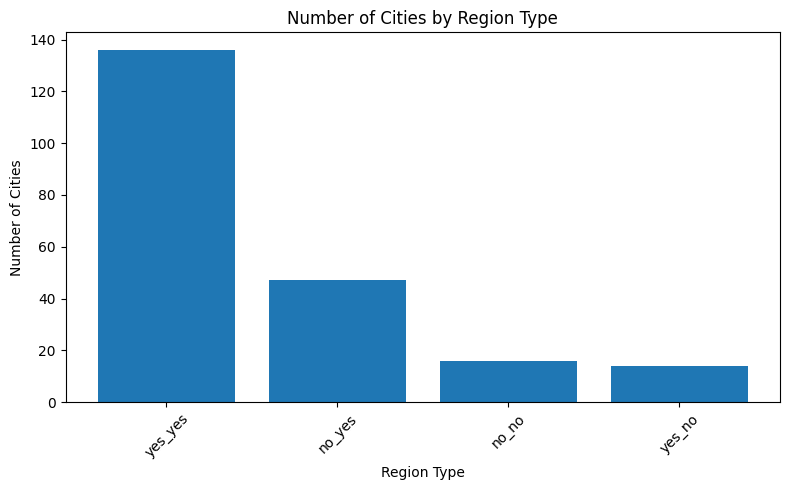

In [5]:
# Compute the number of cities per region type
region_counts = df['region_type'].value_counts()

# Plot a bar chart for the number of cities in each region type
plt.figure(figsize=(8, 5))
plt.bar(region_counts.index, region_counts.values)
plt.xlabel('Region Type')
plt.ylabel('Number of Cities')
plt.title('Number of Cities by Region Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Visualization 2: Scatter Plot of City Locations

Here, we plot the locations of cities on a scatter plot using longitude (x-axis) and latitude (y-axis). Cities belonging to the same country are displayed with the same color.

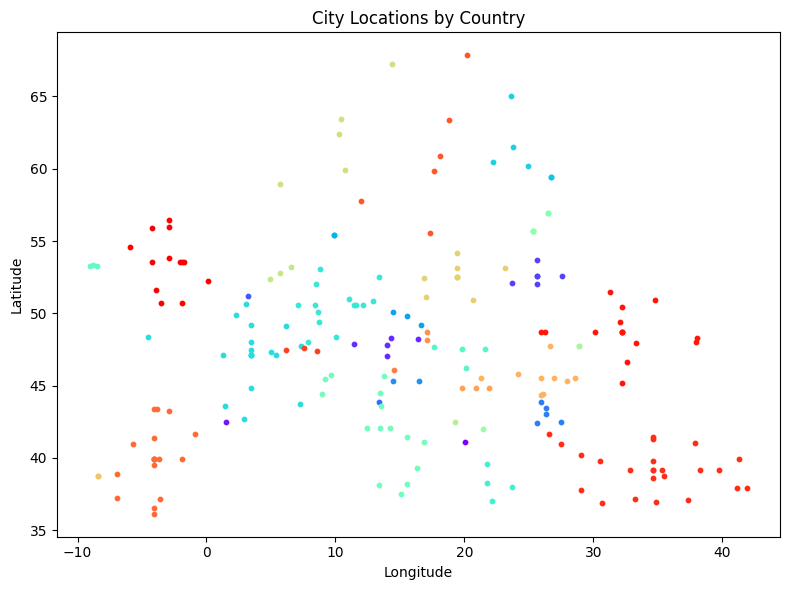

In [6]:
# Create a color map for each country using a rainbow color scale
countries = df['country'].unique()
colors = cm.rainbow(np.linspace(0, 1, len(countries)))
color_map = dict(zip(countries, colors))

plt.figure(figsize=(8, 6))
for country in countries:
    subset = df[df['country'] == country]
    plt.scatter(subset['longitude'], subset['latitude'],
                label=country, color=color_map[country], s=10)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("City Locations by Country")
plt.tight_layout()
plt.show()

## Visualization 3: Histogram of Unique Countries by Population Groups

We divide the `population` column into 5 bins and count the number of unique countries in each bin. The resulting data is visualized using a bar chart.

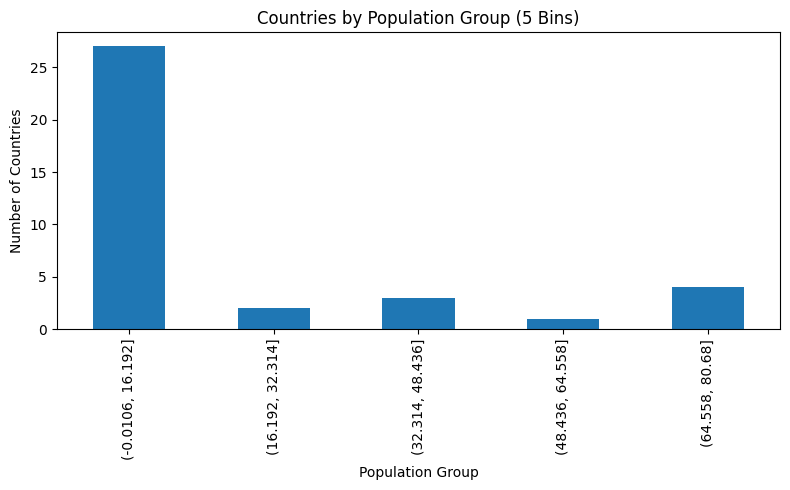

In [10]:
# Divide the population into 5 bins
bins = pd.cut(df['population'], bins=5)

# Count the number of unique countries in each population group
bin_counts = df.groupby(bins, observed=True)['country'].nunique()

# Plot a bar chart for the population groups
bin_counts.plot(kind='bar', figsize=(8, 5))
plt.xlabel('Population Group')
plt.ylabel('Number of Countries')
plt.title('Countries by Population Group (5 Bins)')
plt.tight_layout()
plt.show()

## Visualization 4: Subplots by Region Type

We create a 2x2 grid of scatter plots. Each subplot represents a region type. The x-axis of each plot represents the city index (0 to n-1), and the y-axis represents the latitude.  
Points are colored based on temperature:
- Red: Temperature > 10  
- Blue: Temperature < 6  
- Orange: Temperature between 6 and 10 (inclusive)

In [ ]:
# Prepare subplots for each region type
region_types = df['region_type'].unique()
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Define the function for temperature-based color assignment
def temp_color(t):
    if t > 10:
        return 'red'
    elif t < 6:
        return 'blue'
    else:
        return 'orange'

# Plot each region type on a subplot
for i, region in enumerate(region_types):
    subset = df[df['region_type'] == region].reset_index(drop=True)
    ax = axes[i // 2, i % 2]
    # Apply the color function to the temperature column
    colors = subset['temperature'].apply(temp_color)
    ax.scatter(subset.index, subset['latitude'], c=colors)
    ax.set_title(f'Region: {region}')
    ax.set_xlabel('City Index')
    ax.set_ylabel('Latitude')
    ax.set_xticks(range(len(subset)))
    ax.grid(True)

plt.tight_layout()
plt.show()